## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.optim import lr_scheduler

from tqdm import tqdm
from transformers import DistilBertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset3
from bert import CustomBert3, CustomBert5, CustomBert3b
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from sentence_embed import get_use_embedding_features, get_distill_bert_features
from create_features import get_dist_features, get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, FocalLoss
from inference import infer
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')

In [3]:
train['question'] = train['question_title'] + ' \n \n \n ' + train['question_body']
test['question'] = test['question_title'] + ' \n \n \n ' + test['question_body']

In [4]:
%%time
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
ids_train = {}
ids_test = {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test)]:
    for text in ['question', 'answer']:
        ids = []
        for x in tqdm(df[text].values):
            encoded_inputs = tokenizer.encode_plus(
                x, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True)
            ids.append(encoded_inputs['input_ids'])
        if mode == 'train': ids_train[text] = np.array(ids)
        else: ids_test[text] = np.array(ids)

100%|██████████| 476/476 [00:00<00:00, 486.96it/s]

CPU times: user 26.5 s, sys: 179 ms, total: 26.6 s
Wall time: 26.9 s


In [5]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [6]:
cat_features_train = np.hstack([train_host.reshape(-1, 1), train_category.reshape(-1, 1)])
cat_features_test = np.hstack([test_host.reshape(-1, 1), test_category.reshape(-1, 1)])
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
y = train[TARGETS].values.astype(np.float32)

In [8]:
num_workers = 10
bs = 2

In [9]:
bs_test = 2
test_loader = DataLoader(
    TextDataset3(cat_features_test, ids_test['question'], ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers
)

## Training model

In [10]:
lr = 0.001
loss_fn = FocalLoss()#nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'double_distil_bert'
checkpoint_dir = 'checkpoints/'
early_stopping = None

In [11]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.q_bert, lr / 100, weight_decay)
        + get_optimizer_param_groups(model.a_bert, lr / 100, weight_decay)
    )

Fold 1 started at Thu Jan  2 21:13:40 2020
CustomBert3(
  (q_bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn):

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


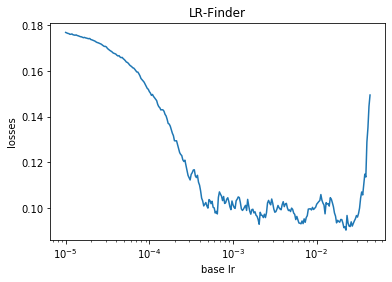

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.094708 - spearmanr 0.20455
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.085553 - spearmanr 0.34702
best model: epoch 0 - 0.34702
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.081682 - spearmanr 0.359
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.082044 - spearmanr 0.38293
best model: epoch 1 - 0.38293
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.076969 - spearmanr 0.41684
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.0813 - spearmanr 0.39148
best model: epoch 2 - 0.39148
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.073288 - spearmanr 0.45929
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.081676 - spearmanr 0.39354
best model: epoch 3 - 0.39354
TRAINING END: Best score achieved on epoch 3 - 0.39354
Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_1_best.pth



Fold 2 started at Thu Jan  2 21:34:15 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.094266 - spearmanr 0.2082
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.088596 - spearmanr 0.33611
best model: epoch 0 - 0.33611
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.081669 - spearmanr 0.36145
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.082509 - spearmanr 0.37881
best model: epoch 1 - 0.37881
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.07687 - spearmanr 0.41816
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.081093 - spearmanr 0.38732
best model: epoch 2 - 0.38732
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.073236 - spearmanr 0.46041
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.081235 - spearmanr 0.39136
best model: epoch 3 - 0.39136
TRAINING END: Best score achieved on epoch 3 - 0.39136
Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_2_best.pth



Fold 3 started at Thu Jan  2 21:53:15 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.0946 - spearmanr 0.20346
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.084251 - spearmanr 0.3529
best model: epoch 0 - 0.3529
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.081982 - spearmanr 0.35818
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.08125 - spearmanr 0.38544
best model: epoch 1 - 0.38544
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.077185 - spearmanr 0.41638
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.080137 - spearmanr 0.40684
best model: epoch 2 - 0.40684
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.073608 - spearmanr 0.45809
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.080137 - spearmanr 0.40644
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40684
Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_3_best.pth



Fold 4 started at Thu Jan  2 22:12:21 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.094536 - spearmanr 0.20882
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.084024 - spearmanr 0.34411
best model: epoch 0 - 0.34411
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.081897 - spearmanr 0.35898
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.082206 - spearmanr 0.37715
best model: epoch 1 - 0.37715
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.077124 - spearmanr 0.4188
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.080457 - spearmanr 0.38674
best model: epoch 2 - 0.38674
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.073536 - spearmanr 0.46323
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.080821 - spearmanr 0.38789
best model: epoch 3 - 0.38789
TRAINING END: Best score achieved on epoch 3 - 0.38789
Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_4_best.pth



Fold 5 started at Thu Jan  2 22:31:20 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.094192 - spearmanr 0.20764
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.085583 - spearmanr 0.3372
best model: epoch 0 - 0.3372
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.081577 - spearmanr 0.36337
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.082213 - spearmanr 0.37789
best model: epoch 1 - 0.37789
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.076889 - spearmanr 0.42119
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.082555 - spearmanr 0.37829
best model: epoch 2 - 0.37829
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.073215 - spearmanr 0.46372
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.08168 - spearmanr 0.38486
best model: epoch 3 - 0.38486
TRAINING END: Best score achieved on epoch 3 - 0.38486
Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



Starting inference for model: checkpoints/double_distil_bert_fold_5_best.pth



OOF score: 0.39035189118747365


In [12]:
init_seed()
folds = GroupKFold(n_splits=5).split(
    X=train['question_body'], groups=train['question_body'])#KFold(n_splits=5, random_state=42).split(train)
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], train_index, y),
        batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=True
    )
    valid_loader = DataLoader(
        TextDataset3(cat_features_train, ids_train['question'], ids_train['answer'], valid_index, y),
        batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
        print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True
    )
    if (fold_id + 1) > 0: learner.train()
    
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / 5
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')
#0.4134


In [13]:
def my_round(x, num, dec=2):
    return np.round(x / num, dec) * num

def round_preds(preds, thres=0.0, low_dec=1, low_num=1, high_dec=2, high_num=3):
    low_idx = preds < thres
    new_preds = np.zeros_like(preds)
    new_preds[low_idx] = my_round(preds[low_idx], low_num, low_dec)
    new_preds[~low_idx] = my_round(preds[~low_idx], high_num, high_dec)
    return new_preds

from scipy.stats import spearmanr
def spearmanr_np(preds, targets):
    score = 0
    for i in range(N_TARGETS):
        score_i = spearmanr(preds[:, i], targets[:, i]).correlation
        score += np.nan_to_num(score_i / N_TARGETS)
    return score

In [14]:
zero_idx = np.where(y.mean(axis=0).round(3)<=0.001)[0][0]

In [15]:
my_round(oofs, 3, 2), oofs

(array([[0.9 , 0.66, 0.27, ..., 0.24, 0.66, 0.84],
        [0.9 , 0.66, 0.15, ..., 0.18, 0.54, 0.87],
        [0.84, 0.48, 0.06, ..., 0.3 , 0.48, 0.9 ],
        ...,
        [0.78, 0.48, 0.06, ..., 0.27, 0.36, 0.75],
        [0.84, 0.66, 0.54, ..., 0.27, 0.69, 0.87],
        [0.84, 0.69, 0.18, ..., 0.18, 0.81, 0.84]]),
 array([[0.89452875, 0.66735208, 0.27074459, ..., 0.24329923, 0.66180557,
         0.84686649],
        [0.89111137, 0.66366225, 0.15674227, ..., 0.18362942, 0.5265584 ,
         0.87793744],
        [0.83109844, 0.48963162, 0.06582707, ..., 0.29216114, 0.48136669,
         0.89415222],
        ...,
        [0.78954935, 0.47199571, 0.0669744 , ..., 0.27073821, 0.36278725,
         0.7478652 ],
        [0.8387509 , 0.65965694, 0.52779472, ..., 0.25981906, 0.69180012,
         0.87480772],
        [0.84708363, 0.6839065 , 0.1819309 , ..., 0.17635141, 0.7989893 ,
         0.84975523]]))

In [16]:
spearmanr_np(oofs, y)

0.39110393616881783

In [17]:
spearmanr_np(np.clip(round_preds(oofs, high_num=2), 0.00001, 0.999999), y)

0.3912406492854529

In [18]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [19]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.823876,0.670267,0.383742,0.438931,0.632696,0.538247,0.657934,0.623395,0.570922,0.075557,0.584066,0.516246,0.163094,0.324986,0.094554,0.126076,0.245303,0.286523,0.613933,0.053562,0.842079,0.750657,0.488345,0.818657,0.830195,0.676671,0.071812,0.167183,0.619469,0.823591
1,46,0.807471,0.485284,0.087637,0.609679,0.644595,0.715437,0.545977,0.471507,0.158648,0.097237,0.504108,0.306117,0.064963,0.043008,0.032550,0.072270,0.792855,0.307353,0.244814,0.021691,0.599878,0.888543,0.657584,0.903934,0.934292,0.855536,0.842547,0.235752,0.148004,0.844078
2,70,0.825502,0.632272,0.114179,0.663338,0.789336,0.842641,0.570783,0.484611,0.301546,0.054837,0.297699,0.650258,0.087927,0.172289,0.046983,0.076422,0.210718,0.189398,0.599461,0.028369,0.802570,0.849610,0.574857,0.882189,0.907177,0.793960,0.099825,0.175371,0.804256,0.866930
3,132,0.819558,0.430735,0.069928,0.620829,0.668277,0.753515,0.531568,0.429749,0.255749,0.091086,0.504794,0.242077,0.065077,0.058402,0.031036,0.085856,0.707147,0.314154,0.486752,0.021028,0.679192,0.864793,0.703431,0.875223,0.910543,0.851348,0.698151,0.310384,0.592694,0.836162
4,200,0.842591,0.443076,0.130383,0.717182,0.705694,0.755774,0.647579,0.629545,0.313938,0.145829,0.393138,0.379316,0.101756,0.149280,0.077395,0.198691,0.357857,0.268192,0.509459,0.065708,0.609394,0.805368,0.659191,0.865235,0.860151,0.755050,0.334108,0.278963,0.549468,0.820874
